In [35]:
!gdown 14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ

Downloading...
From: https://drive.google.com/uc?id=14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ
To: /content/tsukuba.zip
100% 354k/354k [00:00<00:00, 79.3MB/s]


In [36]:
!gdown 1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn

Downloading...
From: https://drive.google.com/uc?id=1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn
To: /content/Aloe_images.zip
100% 1.32M/1.32M [00:00<00:00, 99.3MB/s]


## Disparity Map

In [37]:
!unzip /content/tsukuba.zip
!unzip /content/Aloe_images.zip

Archive:  /content/tsukuba.zip
mapname:  conversion of  failed
replace left.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/Aloe_images.zip
replace Aloe/Aloe_left_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import cv2 # type: ignore
import numpy as np

def abs_distance(x, y):
  return abs(x - y)

def pixel_wise_disparity(left_path, right_path, disparity_range, save_result):
  left = cv2.imread(left_path)
  right = cv2.imread(right_path)
  left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY).astype(np.float32)
  right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY).astype(np.float32)

  height, width = left.shape[:2]
  depth = np.zeros((height, width), dtype=np.float32)

  max_cost = 255
  scale = 16
  for h in range(height):
    for w in range(width):
      cost_min = max_cost
      optimal_disparity = 0
      for dis in range(disparity_range):
        cost = max_cost if (w - dis) < 0 else \
              abs_distance(left[h, w], right[h, w - dis])
        if cost < cost_min:
          cost_min = cost
          optimal_disparity = dis
      depth[h, w] = optimal_disparity * scale

  if save_result:
    print("Saving result...")
    cv2.imwrite("pixel_wise_l1.png", depth)
    cv2.imwrite("pixel_wise_l1_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))
  return depth

ModuleNotFoundError: No module named 'cv2'

In [39]:
def abs_diff(x, y):
  return np.sum(abs(x - y))

def mean_square_error(x, y):
  return np.sum((x - y) ** 2)

In [40]:
def pixel_wise_disparity_l1(left_img, right_img, disparity_range, save_result):
  left = cv2.imread(left_img)
  right = cv2.imread(right_img)
  left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY).astype(np.float32)
  right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY).astype(np.float32)
  height, width = left.shape[:2]
  depth = np.zeros((height, width), dtype=np.float32)
  max_cost = 255
  scale = 16
  for h in range(height):
    for w in range(width):
      cost_min = max_cost
      optimal_disparity = 0
      for dis in range(disparity_range):
        cost = max_cost if (w - dis) < 0 else \
              abs_diff(left[h, w], right[h, w - dis])
        if cost < cost_min:
          cost_min = cost
          optimal_disparity = dis
      depth[h, w] = optimal_disparity * scale

  if save_result:
    print("Saving result...")
    cv2.imwrite("pixel_wise_l1.png", depth)
    cv2.imwrite("pixel_wise_l1_color.png", cv2.applyColorMap(cv2.convertScaleAbs(depth), cv2.COLORMAP_JET))
    print("Done!")
  return depth

In [41]:
def pixel_wise_disparity_l2(left_img, right_img, disparity_range, save_result):
  left = cv2.imread(left_img)
  right = cv2.imread(right_img)
  left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY).astype(np.float32)
  right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY).astype(np.float32)
  height, width = left.shape[:2]
  depth = np.zeros((height, width), dtype=np.float32)
  max_cost = 255
  scale = 16
  for h in range(height):
    for w in range(width):
      cost_min = max_cost
      optimal_disparity = 0
      for dis in range(disparity_range):
        cost = max_cost if (w - dis) < 0 else \
              mean_square_error(left[h, w], right[h, w - dis])
        if cost < cost_min:
          cost_min = cost
          optimal_disparity = dis
      depth[h, w] = optimal_disparity * scale

  if save_result:
    print("Saving result...")
    cv2.imwrite("pixel_wise_l2.png", depth)
    cv2.imwrite("pixel_wise_l2_color.png", cv2.applyColorMap(cv2.convertScaleAbs(depth), cv2.COLORMAP_JET))
    print("Done!")
  return depth

In [42]:
left_img = '/content/left.png'
right_img = '/content/right.png'
disparity_range = 16

pixel_wise_result_l1 = pixel_wise_disparity_l1(left_img, right_img, disparity_range, True)

Saving result...
Done!


In [43]:
pixel_wise_result_l2 = pixel_wise_disparity_l2(left_img, right_img, disparity_range, True)

Saving result...
Done!


In [52]:
from tqdm import tqdm
def window_based_matching(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
  left = cv2.imread(left_img)
  right = cv2.imread(right_img)
  left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY).astype(np.float32)
  right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY).astype(np.float32)
  height, width = left.shape[:2]
  depth = np.zeros((height, width), dtype=np.float32)
  kernel_half = int((kernel_size - 1) / 2)
  scale = 3
  max_value = 255*9
  for h in tqdm(range(kernel_half, height - kernel_half), desc="Processing Rows"):
      for w in range(kernel_half, width - kernel_half):
          optimal_disparity = 0
          cost_min = 65534

          left_window = left[h - kernel_half:h + kernel_half + 1, w - kernel_half:w + kernel_half + 1]

          for dis in range(disparity_range):
              if w - dis < kernel_half:
                  continue

              right_window = right[h - kernel_half:h + kernel_half + 1, w - kernel_half - dis:w + kernel_half + 1 - dis]
              cost = np.sum(np.abs(left_window - right_window))

              if cost < cost_min:
                  cost_min = cost
                  optimal_disparity = dis

          depth[h, w] = optimal_disparity * scale


  if save_result:
    print("Saving result...")
    cv2.imwrite("window_based_right2.png", depth)
    cv2.imwrite("window_based_right2_color.png", cv2.applyColorMap(cv2.convertScaleAbs(depth), cv2.COLORMAP_JET))
    print("Done!")

  return depth

In [51]:
left_img_path = '/content/Aloe/Aloe_left_1.png'
right_img_path = '/content/Aloe/Aloe_right_1.png'
disparity_range =64
window_based_result = window_based_matching(left_img_path, right_img_path, disparity_range, kernel_size=5, save_result=True)

Processing Rows: 100%|██████████| 366/366 [01:14<00:00,  4.90it/s]


Saving result...
Done!


In [55]:
left_img_path = '/content/Aloe/Aloe_left_1.png'
right_img_path = '/content/Aloe/Aloe_right_2.png'
disparity_range =64
window_based_result = window_based_matching(left_img_path, right_img_path, disparity_range, kernel_size=5, save_result=True)

Processing Rows: 100%|██████████| 366/366 [01:16<00:00,  4.77it/s]


Saving result...
Done!


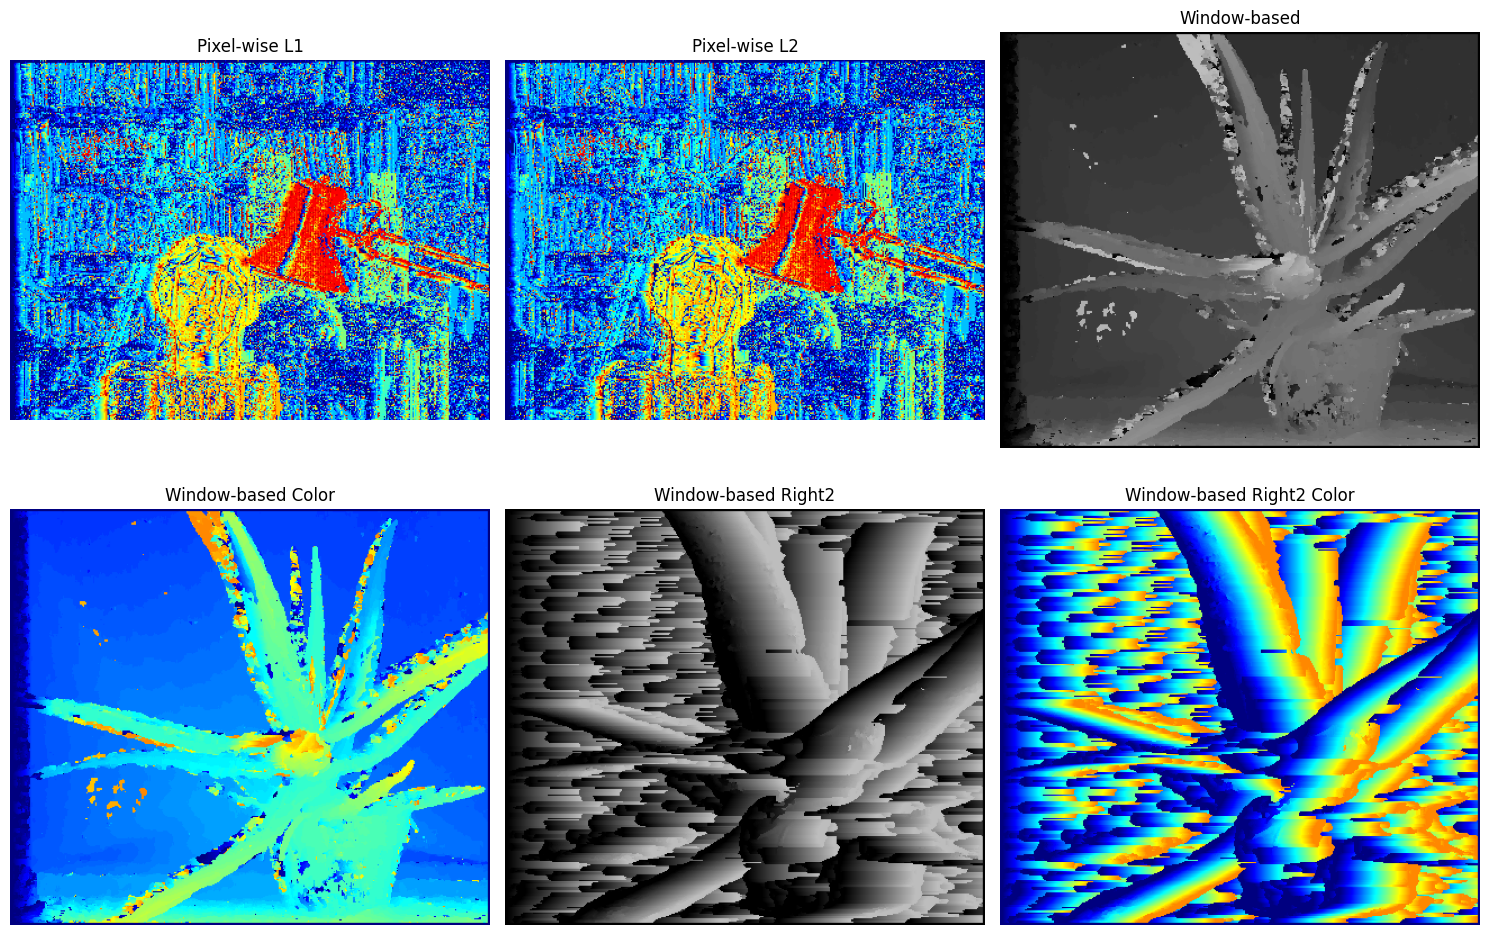

In [58]:
import matplotlib.pyplot as plt
pixel_wise_l1 = cv2.imread('pixel_wise_l1_color.png')
pixel_wise_l2 = cv2.imread('pixel_wise_l2_color.png')
window_based = cv2.imread('window_based.png')
window_based_color = cv2.imread('window_based_color.png')
window_based_right2 = cv2.imread('window_based_right2.png')
window_based_right2_color = cv2.imread('window_based_right2_color.png')

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(pixel_wise_l1, cv2.COLOR_BGR2RGB))
plt.title('Pixel-wise L1')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(pixel_wise_l2, cv2.COLOR_BGR2RGB))
plt.title('Pixel-wise L2')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(window_based, cv2.COLOR_BGR2RGB))
plt.title('Window-based')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(window_based_color, cv2.COLOR_BGR2RGB))
plt.title('Window-based Color')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(window_based_right2, cv2.COLOR_BGR2RGB))
plt.title('Window-based Right2')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(window_based_right2_color, cv2.COLOR_BGR2RGB))
plt.title('Window-based Right2 Color')
plt.axis('off')

plt.tight_layout()
plt.show()


In [59]:
def cosine_similarity(x, y):
  return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [62]:
def window_based_matching(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
  left = cv2.imread(left_img)
  right = cv2.imread(right_img)
  left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY).astype(np.float32)
  right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY).astype(np.float32)
  height, width = left.shape[:2]
  depth = np.zeros((height, width), dtype=np.uint8)
  kernel_half = int((kernel_size - 1) / 2)
  scale = 3
  for h in tqdm(range(kernel_half, height - kernel_half), desc="Processing Rows"):
    for w in range(kernel_half, width - kernel_half):
      optimal_disparity = 0
      cost_optimal = -1
      left_window = left[h - kernel_half:h + kernel_half + 1, w - kernel_half:w + kernel_half + 1]

      for dis in range(disparity_range):
          if w - dis < kernel_half:
              continue
          right_window = right[h - kernel_half:h + kernel_half + 1, w - kernel_half - dis:w + kernel_half + 1 - dis]
          cost = cosine_similarity(left_window.flatten(), right_window.flatten())
          if cost > cost_optimal:
              cost_optimal = cost
              optimal_disparity = dis

      depth[h, w] = optimal_disparity * scale
  if save_result:
    print("Saving result...")
    cv2.imwrite("window_based_cosine.png", depth)
    cv2.imwrite("window_based_cosine_color.png", cv2.applyColorMap(cv2.convertScaleAbs(depth), cv2.COLORMAP_JET))
  return depth


In [63]:
left_img_path = '/content/Aloe/Aloe_left_1.png'
right_img_path = '/content/Aloe/Aloe_right_2.png'
disparity_range =64
window_based_result = window_based_matching(left_img_path, right_img_path, disparity_range,  kernel_size=5, save_result=True)

Processing Rows: 100%|██████████| 366/366 [01:41<00:00,  3.61it/s]

Saving result...


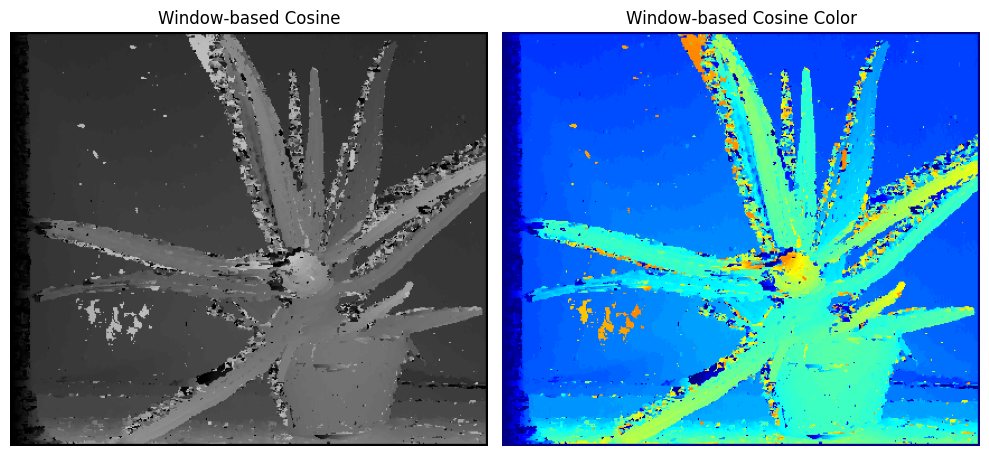

In [64]:
window_based_cosine = cv2.imread('window_based_cosine.png')
window_based_cosine_color = cv2.imread('window_based_cosine_color.png')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(window_based_cosine, cv2.COLOR_BGR2RGB))
plt.title('Window-based Cosine')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(window_based_cosine_color, cv2.COLOR_BGR2RGB))
plt.title('Window-based Cosine Color')
plt.axis('off')

plt.tight_layout()
plt.show()
